In [1]:
# %%bash
# apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
# pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
# echo "Installation is done."


Installation is done.


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-h9i_1nc4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.18.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.
notebook 6.5.5 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.0 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 25.1.2 which is incompatible.


### Segmentation network based on Unet and Resnet50



In [2]:
import logging
import warnings

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm

from tiatoolbox import logger
from tiatoolbox.models.architecture.unet import UNetModel
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
from tiatoolbox.utils.misc import download_data, imread
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
warnings.filterwarnings("ignore")

|2024-01-10|10:56:40.342| [INFO] NumExpr defaulting to 2 threads.


In [3]:
ON_GPU = True

In [15]:
%%bash
rm -rf tmp
echo "deleting tmp directory"
rm -r sample_tile_results
echo "deleting 'sample_tile_results' directory"
rm -r sample_wsi_results
echo "deleting 'sample_wsi_results' directory"
rm -r tissue_mask_results
echo "deleting 'tissue_mask_results' directory"

deleting tmp directory
deleting 'sample_tile_results' directory
deleting 'sample_wsi_results' directory
deleting 'tissue_mask_results' directory


rm: cannot remove 'sample_wsi_results': No such file or directory
rm: cannot remove 'tissue_mask_results': No such file or directory


In [17]:
# These file name are used for
img_file_name = "test2.png"
wsi_file_name = "sample_wsi.svs"
mini_wsi_file_name = "mini_wsi.svs"
model_file_name = "tissue_mask_model.pth"

logger.info("Download has started. Please wait...")

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs",
    wsi_file_name,
)

# Downloading mini whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1.ndpi",
    mini_wsi_file_name,
)

# Download external model
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth",
    model_file_name,
)

logger.info("Download is complete.")

|2024-01-10|11:45:09.244| [INFO] Download has started. Please wait...
|2024-01-10|11:45:09.247| [INFO] Download is complete.


In [18]:
# Tile prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4,
    batch_size=4,
)

output = bcc_segmentor.predict(
    [img_file_name],
    save_dir="sample_tile_results/",
    mode="tile",
    resolution=1.0,
    units="baseline",
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[512, 512],
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

|2024-01-10|11:45:10.422| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2024-01-10|11:45:10.533| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2024-01-10|11:45:10.611| [WARNING] Raw data is None.
|2024-01-10|11:45:10.613| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch:   0%|                                      | 0/3 [00:00<?, ?it/s]|2024-01-10|11:45:10.941| [WARNING] Raw data is None.
|2024-01-10|11:45:11.004| [WARNING] Raw data is None.
|2024-01-10|11:45:11.076| [WARNING] Raw data is None.
Process Batch: 100%|##############################| 3/3 [00:02<00:00,  1.14it/s]

|2024-01-10|11:45:13.273| [INFO] Finish: 0
|2024-01-10|11:45:13.275| [INFO] --Input: test2.png
|2024-01-10|11:45:13.277| [INFO] --Output: /content/sample_tile_results/0


|2024-01-10|11:45:13.489| [INFO] Prediction method output is: test2.png, /content/sample_tile_results/0
|2024-01-10|11:45:13.515| [INFO] Raw prediction dimensions: (1072, 2016, 5)
|2024-01-10|11:45:13.540| [INFO] Processed prediction dimensions: (1072, 2016)
|2024-01-10|11:45:13.602| [INFO] Input image dimensions: (1072, 2016, 3)


Text(0.5, 0.82, 'Processed prediction map')

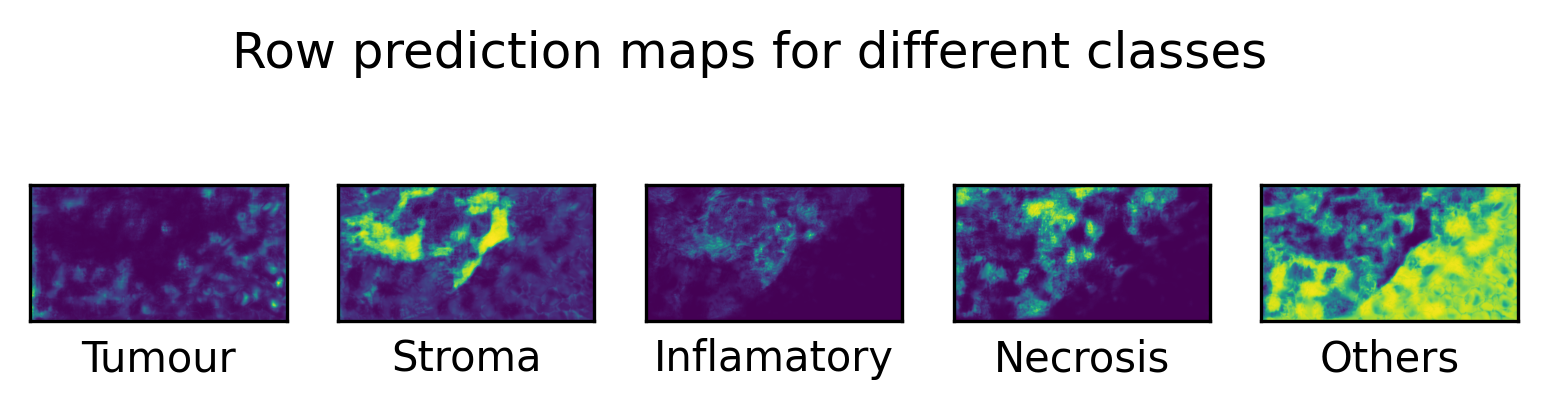

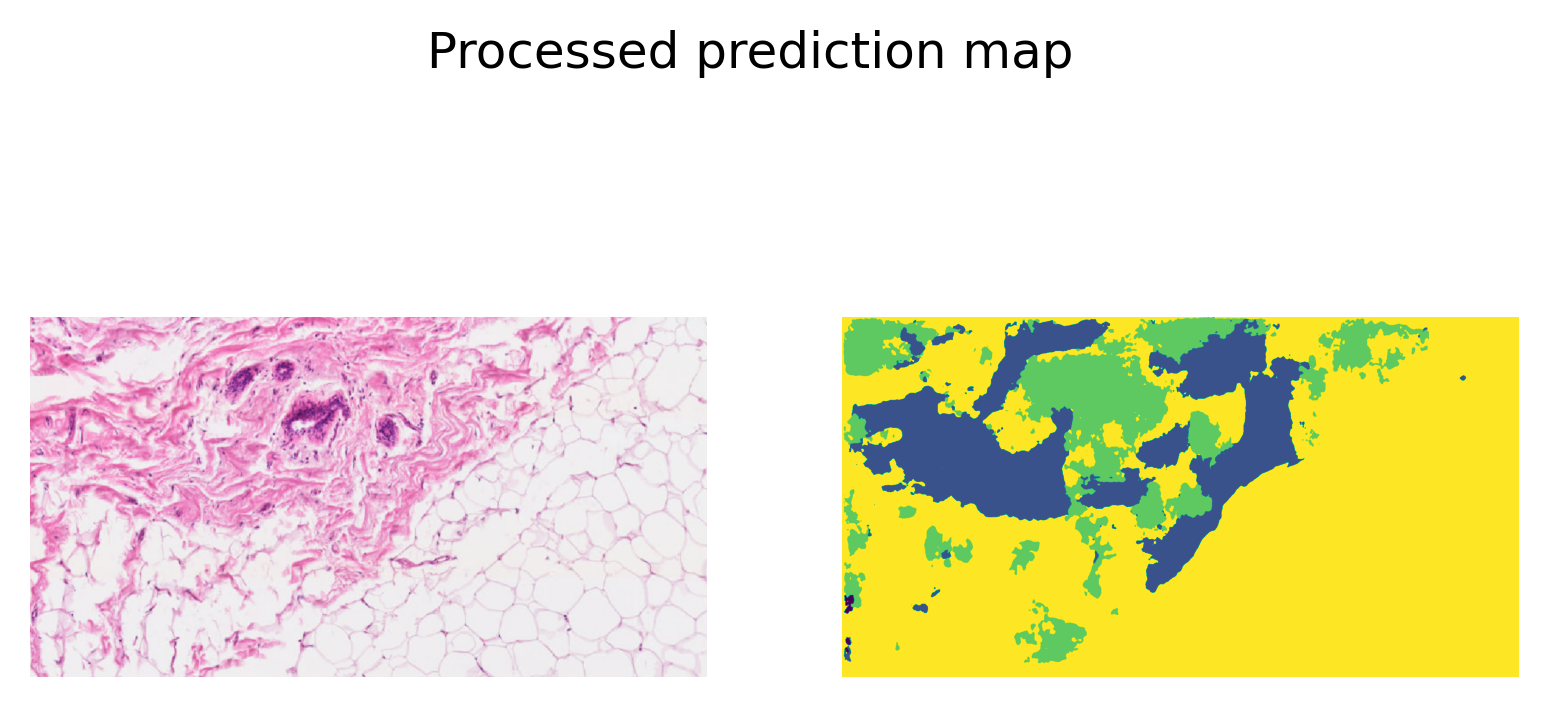

In [19]:
logger.info(
    "Prediction method output is: %s, %s",
    output[0][0],
    output[0][1],
)
tile_prediction_raw = np.load(
    output[0][1] + ".raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]
logger.info(
    "Raw prediction dimensions: (%d, %d, %d)",
    tile_prediction_raw.shape[0],
    tile_prediction_raw.shape[1],
    tile_prediction_raw.shape[2],
)

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(
    tile_prediction_raw,
    axis=-1,
)  # select the class with highest probability
logger.info(
    "Processed prediction dimensions: (%d, %d)",
    tile_prediction.shape[0],
    tile_prediction.shape[1],
)

# showing the predicted semantic segmentation
tile = imread(img_file_name)
logger.info(
    "Input image dimensions: (%d, %d, %d)",
    tile.shape[0],
    tile.shape[1],
    tile.shape[2],
)

fig = plt.figure()
label_names_dict = {
    0: "Tumour",
    1: "Stroma",
    2: "Inflamatory",
    3: "Necrosis",
    4: "Others",
}
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(tile_prediction_raw[:, :, i]), plt.xlabel(
        label_names_dict[i],
    ), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])
fig.suptitle("Row prediction maps for different classes", y=0.65)

# showing processed results
fig2 = plt.figure()
ax1 = plt.subplot(1, 2, 1), plt.imshow(tile), plt.axis("off")
ax2 = plt.subplot(1, 2, 2), plt.imshow(tile_prediction), plt.axis("off")
fig2.suptitle("Processed prediction map", y=0.82)